In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Char-RNN (stateless RNN)

Guessing the next character at a time.

### Splitting a seq into batches of shuffled windows

Don't know what this is for yet.

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps=5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


### Loading the data and prepping the Dataset

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [4]:
print (shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

Fitting a tokenizer to the text, this is to encode the characters to integers.

In [6]:
#char_level = True b/c default is word level tokenizing
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index) # num of distinct characters
dataset_size = tokenizer.document_count # total num of characters

In [10]:
#subtracting 1 so that Id's start at 0...
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

### Split a Sequential Dataset

To avoid any overlap, want a gap between the sets. The text talks about the difficulty of splitting a time series. There is an assumption that is made when splitting across time, that the patterns in the past will hold inot the future, which works in some places but not others. When we can make the assumption, the time series is called *stationary*. When its not, it looks like things stock market data which is quite volatile and patterns are taken advanatge of right when their found. 

To make sure that the time series is stationary, you can plot the models errors on a the validation set across time: if it performs better at the start of the validation set than the end, then it might not be stationary and should train the model on a shorter time span.

We take 90% of the data to train on below, and create a Dataset that will return each character 1by1 from the set:

In [15]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### Chopping Sequential Dataset into Multiple Windows

There are over 1 million characters in the seq now and cant just throw it into an RNN as a one long seq. Using the dataset's `window()` method, will convert seq into smaller windows of text. The instances will be short, and the RNN will unroll over the length of these substrings, whhich is called *truncated backpropagation*.

In [16]:
n_steps = 100
window_length = n_steps + 1 #target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

`window()` will create non-overlapping windows by default, so `shift=1` will make it so that the first batch is 0 to 100, the second 1 to 101, and so on. To make sure that there are exactly 101 characters per batch, `drop_remainder=True` so that the last 100 windows dont have 100, 99,98...2,1 characters in them. 

`window()` method creates a dataset that contains windows, each of which is also a dataset, so its nested datasets. Useful when trying to call the datasets methods (like shuffle or batch), but can't use it for training since model expects tensors as inputs. `flat_map()` will convert the nested dataset into one flat one.

Throwing a function into `flat_map()` can transform it before flattening, below we are making batches size (n_steps + 1) in the flatten dataset.

In [17]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:,:-1], windows[:,1:]))

In [20]:
dataset = dataset.map(lambda 
                      X_batch,
                      Y_batch: (tf.one_hot(X_batch, depth=max_id), 
                                Y_batch))


In [21]:
dataset = dataset.prefetch(1)

In [24]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


### Creating and Training the Model

In [25]:
# this is slow as hell, two hours per epoch
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None,max_id],
                    dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, dropout=0.2,
                    recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch = train_size // batch_size,
                   epochs=10)

Epoch 1/10
   62/31370 [..............................] - ETA: 2:40:01 - loss: 3.1292

KeyboardInterrupt: 

### Generating Text

If the model is trained...

In [26]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [28]:
#X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
#tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

#outputs 'u'

Now we want to generate text, dont want to find the last character and then refeed that to find the next and so on, b/c it tends to repeat itseelf. 

So we pick the next character randomly, which will diversify the text. The `categorical()` function samples random class indices, given the class log probabilites (logits). Can also set the temperature, where closer to 0 gives high prob characters, higher temperatures will give each character an equal prob.

In [29]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], 
                      num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

In [30]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [31]:
tf.random.set_seed(42)

#next_char("How are yo", temperature=1)

#outputs 'u'

In [32]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [34]:
tf.random.set_seed(42)

# print(complete_text("t", temperature=0.2))

'''the belly the charges of the other words
and belly '''

# print(complete_text("t", temperature = 1))

'''thing! they know't.

biondello:
for you are the own'''

# print(complete_text("t", temperature=2))

'''th no cyty
use ffor was firive this toighingaber; b'''

'th no cyty\nuse ffor was firive this toighingaber; b'

## Stateful RNNs

Stateless RNN's at each training iteration start with a hidden state full of zeros, updates them at each time step, then throws them out at the last time step. A stateful RNN preserves the hidden states across batches which helps the model learn across long seqs.

Have to use sequential and nonoverlapping input sequences rather than shuffled and overlapping like in stateless RNNs. So we got to have `shift=n_steps` and not call `shuffle()`. 

In [35]:
tf.random.set_seed(42)

In [36]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
#getting the train seq and the target
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(lambda X_batch, Y_batch:
                     (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Chopping the text into 32 texts of equal length, creating one dataset of consecutive input seqs for each, then using `tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))` to create the proper consecutive batches. 

In [38]:
batch_size= 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: 
                                                  tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:,:-1],windows[:,1:]))
dataset = dataset.map(lambda X_batch, Y_batch:
                     (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [39]:
# set stateful=True and needs to know the batch_size
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                    dropout=0.2, recurrent_dropout=0.2,
                    batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                    dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                   activation="softmax"))
])

In [40]:
#need to reset the states before going back to the beginning of the text
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [41]:
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=10,
                   callbacks=[ResetStatesCallback()])

Epoch 1/10
313/313 [==============================] - 82s 261ms/step - loss: 2.6144
Epoch 2/10
313/313 [==============================] - 78s 249ms/step - loss: 2.2245
Epoch 3/10
313/313 [==============================] - 82s 262ms/step - loss: 2.4954
Epoch 4/10
 89/313 [=======>......................] - ETA: 54s - loss: 2.5041

KeyboardInterrupt: 

After its trained, its only possible to use it to make predictions for batches of the same size used during training. To get around this, create a stateless RNN and copy the weights into it. 

In [42]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None,max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                   activation="softmax"))
])

In [43]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [44]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

## Sentiment Analysis

Some options for tokenizing:
- 2018 paper by Taku Kudo, google made an implementation *SentencePiece*
- *byte pair encoding*
- TF.Text, which includes byte pair encoding.


In [45]:
tf.random.set_seed(42)

In [46]:
(X_train, y_train), (X_valid, y_valid) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 1s 0us/step


In [47]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [48]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [55]:
# setting up to deploy model to mobile
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [50]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [51]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [52]:
train_size, test_size

(25000, 25000)

In [56]:
# looking at the data
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [57]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>",b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z' ]", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

Starts by truncating reviews, keeping only the first 300 characters, it will speed up the training and wont impact performance too much since the sentiment of a review is usually pretty obvious. 

Next, using regex, replaces <br/ > tags with spaces and any other character other than letters and quotes with spaces. 

Finally, split reviews by spaces, returning a ragged tensor, converting to a dense tensor, padding all the reviews with padding token.

In [59]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [60]:
# building the vocabulary
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [63]:
vocabulary.most_common()[:20]

[(b'<pad>', 214309),
 (b'the', 61137),
 (b'a', 38564),
 (b'of', 33983),
 (b'and', 33431),
 (b'to', 27707),
 (b'I', 27019),
 (b'is', 25719),
 (b'in', 18966),
 (b'this', 18490),
 (b'it', 17690),
 (b'was', 14950),
 (b'movie', 14945),
 (b'that', 14752),
 (b'The', 11879),
 (b'film', 10668),
 (b'with', 9073),
 (b'for', 8660),
 (b'as', 8578),
 (b'on', 7817)]

In [64]:
len(vocabulary)

53893

In [65]:
#dont need everything so, keep 10k most common
vocab_size= 10000
truncated_vocabulary = [word for word,
                       count in vocabulary.most_common()[:vocab_size]]

In [68]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
#this will print out the id or if its not in the vocab, the vocab_size
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [70]:
#creating lookup table 
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
#think the amount of buckets is to handle out of vocab word ids.
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [71]:
#faaaantastic wasn't found so it was given a id higher than 10000
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

TF Transform (ch13) has some functions to deal with vocabs like this. `tft.compute_and_apply_vocabulary()` will go through dataset, finding all distinct words, build vocab, and generate the TF operations required to encode each word. 

In [72]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch
#batch the reviews and convert to short seqs
train_set = datasets["train"].repeat().batch(32).map(preprocess)
#encode words using the lookup table and prefetch next batch
train_set = train_set.map(encode_words).prefetch(1)

In [73]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [74]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                          mask_zero=True, input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 114s 146ms/step - loss: 0.5305 - accuracy: 0.7282
Epoch 2/5
781/781 [==============================] - 113s 144ms/step - loss: 0.3459 - accuracy: 0.8554
Epoch 3/5
781/781 [==============================] - 114s 146ms/step - loss: 0.1913 - accuracy: 0.9319
Epoch 4/5
781/781 [==============================] - 137s 175ms/step - loss: 0.1341 - accuracy: 0.9535
Epoch 5/5
781/781 [==============================] - 119s 152ms/step - loss: 0.1011 - accuracy: 0.9624


The first layer converts word Id's into embeddings (ch13). Embedding matrix needs to have one row per word Id (`vocab_size + num_oov_buckets`) and one col per embedding dimension (which is 128 here and its a hyperparemeter).

The inputs of this model are 2D tensors of shape *[batch size, time steps]* and the output of the Embedding layer is a 3D tensor of shape *[batch size, time steps, embedding size].

Setting `mask_zero=True` will tell the model to ignore the zero padding and not train on it.

## Masking

All layers must support masking. Pg. 539 gives a breakdown on how the model passes down the mask from the Embedding layer to the others, and how to ensure there is masking support.

Masking layers and automatic mask propogation work best for `Sequential` models. for more complex models, need to explicitly comput mask and pass it to layers using Functional or Subclassing API. 

Following model is identical to the one above and done manually:

In [75]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences= True)(z, mask=mask)
z = keras.layers.GRU(128)(z,mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history=model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 111s 142ms/step - loss: 0.5425 - accuracy: 0.7156
Epoch 2/5
781/781 [==============================] - 111s 142ms/step - loss: 0.3475 - accuracy: 0.8566
Epoch 3/5
781/781 [==============================] - 110s 141ms/step - loss: 0.1753 - accuracy: 0.9385
Epoch 4/5
781/781 [==============================] - 109s 140ms/step - loss: 0.1307 - accuracy: 0.9525
Epoch 5/5
781/781 [==============================] - 110s 141ms/step - loss: 0.1115 - accuracy: 0.9582


## Reusing Pretrained Embeddings

Can download model components called *modules* from Tensorflow Hub.

In [76]:
tf.random.set_seed(42)

In [77]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [81]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                  dtype=tf.string, input_shape=[],output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

This particular module downloaded through the hub.KerasLayer is a sentence encoder: it takes strings as input and encodes each input into a single vector(50 dim vector in this case). It parses the string (splits words on spaces) and embeds each word using an embedding matrix that was pretrain a large seven billion word long corpus, and the computes the mean of all the embeddings.

A `hub.KerasLayer` is not by default trainable.

Some of these TF Hub modules dont support TF 2. 

Searching up the URL for the module will get the documentation for it.

`os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR` this will download the module files permanently to the folder TFHUB_CACHE_DIR

In [82]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [83]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [84]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits['train'].num_examples
batch_size = 32
train_set = datasets['train'].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch = train_size // batch_size,
                   epochs=5)

Epoch 1/5
781/781 [==============================] - 156s 199ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
781/781 [==============================] - 153s 196ms/step - loss: 0.5129 - accuracy: 0.7495
Epoch 3/5
781/781 [==============================] - 149s 191ms/step - loss: 0.5082 - accuracy: 0.7530
Epoch 4/5
781/781 [==============================] - 149s 191ms/step - loss: 0.5047 - accuracy: 0.7533
Epoch 5/5
781/781 [==============================] - 149s 190ms/step - loss: 0.5015 - accuracy: 0.7560


## Encoder-Decoder Network

The diagram is key here. pg. 543.

At Training:
Steps:
- Starts with encoder taking in English sentences, they are fed in backwards so that the decoder can put the start-of-seq(SOS) token on it.
- Each word is represented by its ID and then turned into its embedding that is fed into an embedding layer and the decoder. 
- The decoder outputs a score for each word in the vocab and then the softmax layer turns those scores into probabilities. (basically classification)


Additional details:
- Use masking to handle sentences of varying lengths, can't crop them like we did with sentiment analysis. Group them into buckets by similar lengths so that the padding will by similar in each bucket. There is a `tf.data.experimental.bucket_by_sequence_length()` function that can help.
- An end-of-seq(EOS) token is put at the end of the decoder output and we want to ignore anything past that. Anything after the EOS doesn't contribute to loss.
- With a large output vocab, outputing a prob for each and every possible word would be a bad idea computatively. To avoid this, a solution is to look at only the logits output by the model for the correct word and for a random sample of incorrect words, then compute an approximation of the loss based on those logits. `tf.nn.sampled_softmax_loss()` can do this during training, but regular softmax needs be used at inference time because sampled softmax requires knowing the target.


Basic Encoder-Decoder model:


In [ ]:
tf.random.set_seed(42)

In [ ]:
vocab_size = 100
embed_size = 10

In [87]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(decoder_embeddings,
                                                            initial_state = encoder_state,
                                                            sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs,
                                  sequence_lengths],
                          outputs=[Y_proba])
                                    

In [88]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")


X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 23s 713ms/step - loss: 6.1257
Epoch 2/2
32/32 [==============================] - 22s 677ms/step - loss: 4.6630


Set `return_state=True` for the LSTM so that we get its final hidden state. The LSTM will return two hidden states, short term and long term. 

The `TrainingSampler`'s role is to tell the decoder at each step what it should pretend the previous output was. During inference, it should be embedding of the token that was actually output. During training, it will be the embedding of the previous target token. 

In practice, its a good idea to start training with embedding of the target of teh previous time step and slowly transition to using embedding of actual token that was output at the previous step. Can use `ScheduledEmbeddingTrainingSampler` for this.


## Bidirectional RNN's

In forecasting time series, we can't look ahead, but with NLP tasks it can be preferable to look ahead, so we can use bidirectional layer.

In [89]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None,10]),
    #doubles the number of outputs since it runs in reverse also and concats
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


## Beam Search

Often the most likely word isn't necessairly right, beam search keeps track of the top k most promising sentences, and at each decoder step tries to extend them by one word, keeping only the *k* most likely sentences. The parameter *k* is the *beam width*.

The idea is that it will look at two sentence combinations for example and then three sentence combinations, multiplying the probs for each word and seeing which are the hightest and then looking at three sentence combinations and it should remove any low prob sentences. 

This is good for short sentence translations, but again, not very strong over long sentences.

## Attention Mechanisms

Can be used to caption pictures. A conv neural network process image and outputs features maps, then a decoder RNN with attention mechanism generates the caption.
Has explainability. You can go back and see where the models focus on the image was.

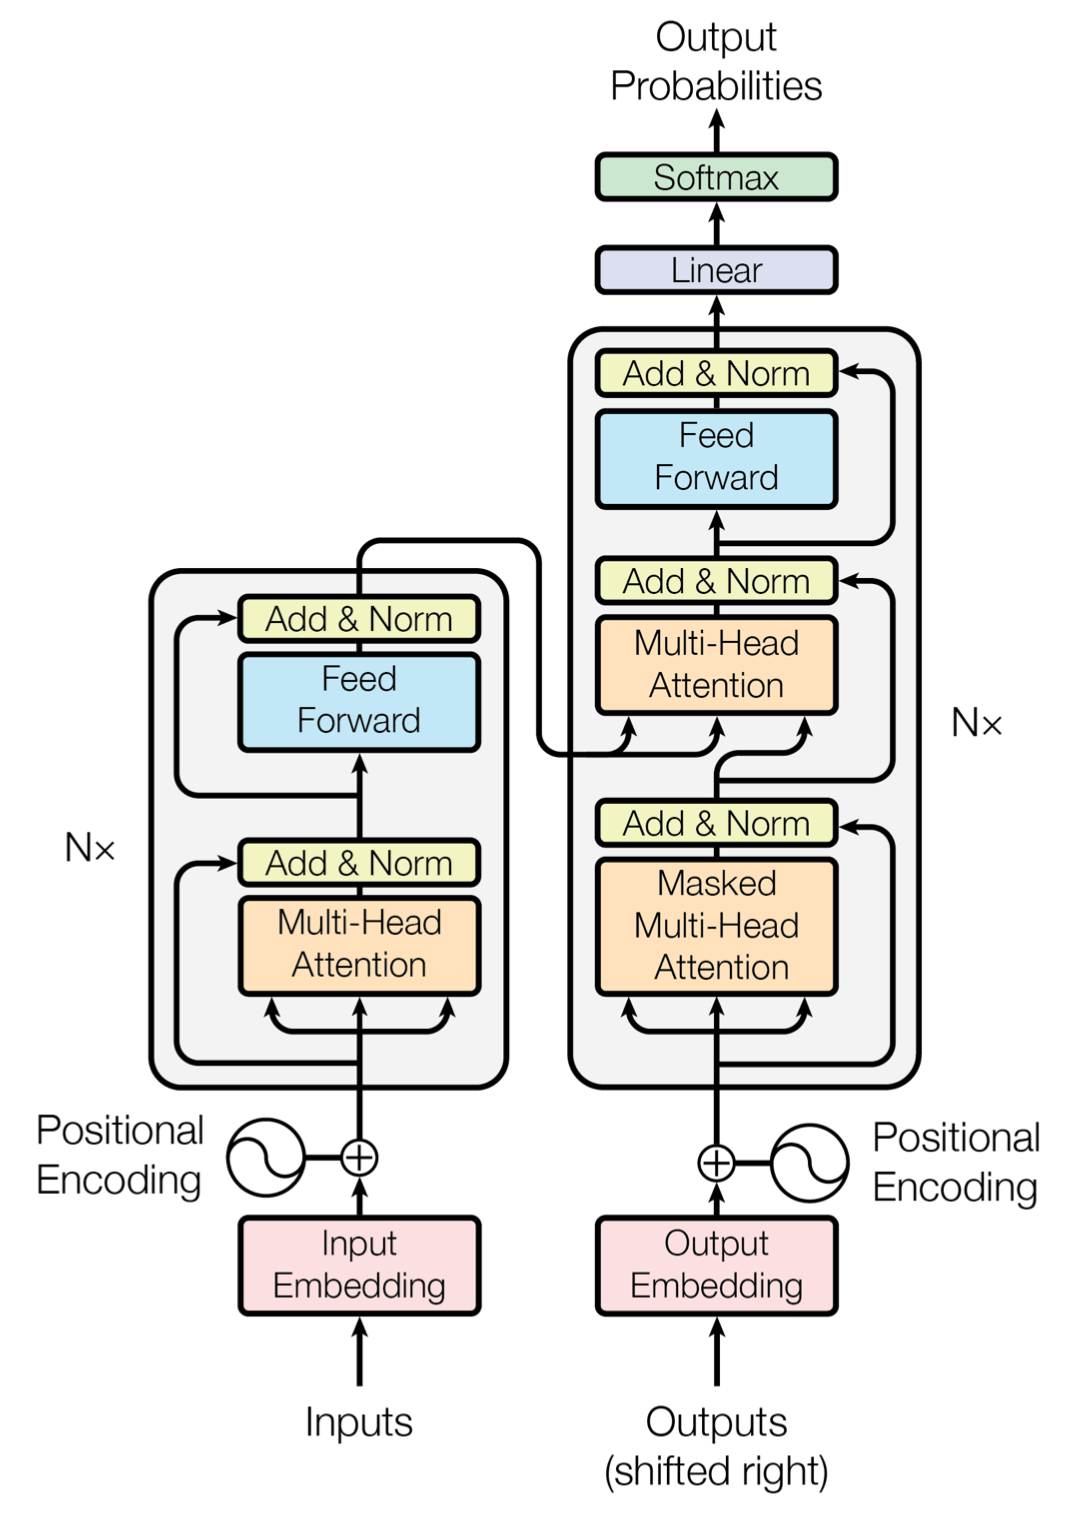

Left hand side is the encoder. Takes in a batch of sentences as seqs of word ID's (shape is *[batch size, max input sentence length]*) and encodes each word into a 512 dimensional representation so the output of the encoder is *[batch size, max input sentence length]*

Right hand side is decoder. During training, 